<a href="https://colab.research.google.com/github/JValdez777/asl-translator-notebook/blob/main/aiASLProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing needed libraries

In [ ]:
!pip install --quiet --upgrade mediapipe==0.10.21
!pip install --quiet opencv-python torch torchvision numpy matplotlib
!pip freeze > requirements.txt

Sprint 1: setup webcam functionality and mediapipe hands.
Goals:
Understand MediaPipe API calls.

For mounting onto drive and importing pretrained ai model.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# For now, comment out loading weights—use a stub
# model.load_state_dict(torch.load(...))
# model.eval()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Checking if everything imported and is working properly

In [ ]:
import cv2
import mediapipe as mp
import torch

# Check that the 'solutions' namespace is present
print("Has solutions module?", hasattr(mp, "solutions"))

# Now check inside solutions for the hands API
print("Has hands in solutions?", hasattr(mp.solutions, "hands"))

print("OpenCV:", cv2.__version__)
print("Torch:", torch.__version__)


Has solutions module? True
Has hands in solutions? True
OpenCV: 4.11.0
Torch: 2.6.0+cu124


Python for setting up mediapipe and encoding a jpeg into a numpy array for processing within js script.


In [ ]:
from google.colab import output
from IPython.display import clear_output
import cv2
import numpy as np
import base64
import mediapipe as mp
from google.colab.patches import cv2_imshow

#setting up mediapipe hands | making a max of two hand objects then setting detection confidence
mp_hands = mp.solutions.hands.Hands(
    max_num_hands=2,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
)
mp_draw = mp.solutions.drawing_utils

def process_frame(data_url):
  #prevents stacking of multiple frames
  clear_output(wait=True)
  #decode base64 jpeg into numpy array
  header, encoded = data_url.split(',',1)
  frame_bytes = base64.b64decode(encoded)
  arr = np.frombuffer(frame_bytes, dtype=np.uint8)
  frame = cv2.imdecode(arr, flags=cv2.IMREAD_COLOR)

  #running media pipe hand detection
  rgb_frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
  results = mp_hands.process(rgb_frame)

  #drawing hand landmarks
  if results.multi_hand_landmarks:
    for hand_landmarks in results.multi_hand_landmarks:
      mp_draw.draw_landmarks(
          frame,
          hand_landmarks,
          mp.solutions.hands.HAND_CONNECTIONS
      )

    #stub asl prediction ai model wil be used here
    pred = "A"
    cv2.putText(
        frame, pred,
        org=(10,30),
        fontFace = cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=1,
        color=(0,255,0),
        thickness=2
    )

    #showing annoted frame inline from output
    cv2_imshow(frame)

  #register this function so JS can call it by name
output.register_callback('notebook.process_frame',process_frame)

print("process_frame callback registered")


process_frame callback registered


<!-- 1. Creating and displaying a video element within the notebook-->
<!-- 2. invoking a async funciton to
  a) ask browser for webcam access
  b) send frames to python-->
<!-- 2a) Getting video element we set up in step 1-->
<!-- 2b) Asking user for webcam permissions and getting the live stream-->

<!-- 3. Setting up timer interval so that every 100 ms:
  a) Draws the current video frame onto an off-screen canvas
  b) encodes this canvas as a jpeg data-url (Base64 string)
  c) send this back to python using colab's callback api-->

<!-- error handling for camera
  if the camera fails log error and alert-->

 1. Creating and displaying a video element within the notebook
 2. invoking a async funciton to
  a) ask browser for webcam access
  b) send frames to python
2a) Getting video element we set up in step 1
2b) Asking user for webcam permissions and getting the live stream

 3. Setting up timer interval so that every 100 ms:
  a) Draws the current video frame onto an off-screen canvas
  b) encodes this canvas as a jpeg data-url (Base64 string)
  c) send this back to python using colab's callback api

error handling for camera
  if the camera fails log error and alert

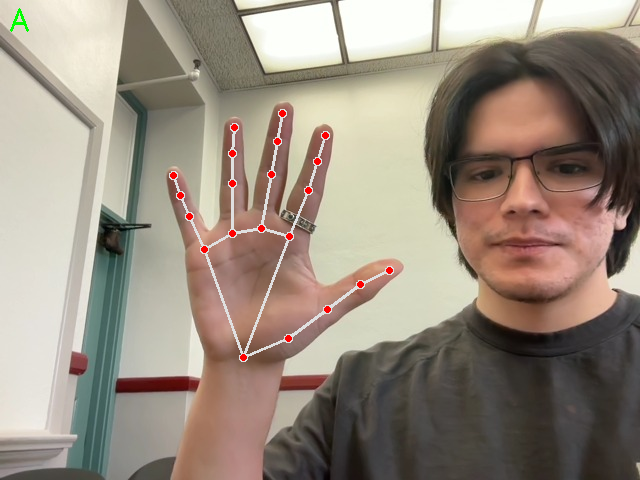

In [ ]:
%%html
<!-- 1. Creating and displaying a video element within the notebook-->
<video id="cam" width="640" height="480" autoplay playsinline></video>
<!-- 2. invoking a async funciton to
  a) ask browser for webcam access
  b) send frames to python-->
<script>
(async function(){
  const video = document.getElementById('cam');
  try{
    //asking for webcam access
    const stream = await navigator.mediaDevices.getUserMedia({video: true});
    video.srcObject = stream;

    //every 100 ms grabe a frame to send to python
    setInterval(() => {
      //draw video onto off-screen canvas
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video,0,0);

      //converts canvas to jpeg data url
      const dataUrl = canvas.toDataURL('image/jpeg');

      //invoke python callback with string (data url)
      google.colab.kernel.invokeFunction(
        'notebook.process_frame',
        [dataUrl],
        {}
      );
    }, 100);
  }
  catch(err){
    console.error('Camera error:', err);
    alert('Could not access camera: ' + err.message);
  }
})();
</script>
